In [468]:
import warnings

warnings.filterwarnings("ignore")
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf



In [469]:
# Define initial parameters
INIT_LR = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 5




In [470]:
# Define classes and base path
classes = ['Fire', 'Non_Fire']
base_path = '/Users/surajojha/Downloads/Fire_Detector/Fire'
output_dir = '/Users/surajojha/Downloads/output'


In [471]:
# Initialize lists for images and labels
images = []
labels = []

# List all files in the base path directory
file_list = os.listdir(base_path)
print(f"Files in base path: {file_list}")


Files in base path: ['63.jpg', '189.jpg', '77.jpg', '162.jpg', '176.jpg', '88.jpg', '200.jpg', '177.jpg', '89.jpg', '163.jpg', '188.jpg', '76.jpg', '62.jpg', '74.jpg', '60.jpg', '48.jpg', '149.jpg', '175.jpg', '161.jpg', '160.jpg', '174.jpg', '148.jpg', '49.jpg', '61.jpg', '75.jpg', '59.jpg', '71.jpg', '65.jpg', '170.jpg', '164.jpg', '158.jpg', '159.jpg', '165.jpg', '171.jpg', '64.jpg', '70.jpg', '58.jpg', '8.jpg', '198.jpg', '66.jpg', '72.jpg', '167.jpg', '99.jpg', '173.jpg', '172.jpg', '166.jpg', '98.jpg', '73.jpg', '199.jpg', '67.jpg', '9.jpg', '14.jpg', '28.jpg', '129.jpg', '101.jpg', '115.jpg', '114.jpg', '100.jpg', '128.jpg', '29.jpg', '15.jpg', '17.jpg', '116.jpg', '102.jpg', '103.jpg', '117.jpg', '16.jpg', '12.jpg', '113.jpg', '107.jpg', '106.jpg', '112.jpg', '13.jpg', '39.jpg', '11.jpg', '104.jpg', '110.jpg', '138.jpg', '139.jpg', '111.jpg', '105.jpg', '10.jpg', '38.jpg', '21.jpg', '35.jpg', '108.jpg', '120.jpg', '134.jpg', '135.jpg', '121.jpg', '109.jpg', '34.jpg', '20.jpg', 

In [472]:
# Process each file
for img_filename in file_list:
    img_path = os.path.join(base_path, img_filename)
    print(f"Loading image: {img_path}")

    # Load the image
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (128, 128))
        images.append(img)
        # Determine the label based on filename (assuming filename contains class info)
        label = 1 if 'Fire' in img_filename else 0
        labels.append(label)
    else:
        print(f"Failed to load image: {img_path}")


Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/63.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/189.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/77.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/162.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/176.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/88.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/200.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/177.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/89.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/163.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/188.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/76.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/62.jpg
Loading image: /Users/surajojha/Downloads/Fire_Detector/Fire/74.jpg
Loading image: /Users/surajojha/Downloads

In [473]:
# Convert lists to numpy arrays
images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)


In [474]:
# Convert labels to one-hot encoded format
labels = utils.to_categorical(labels, num_classes=2)

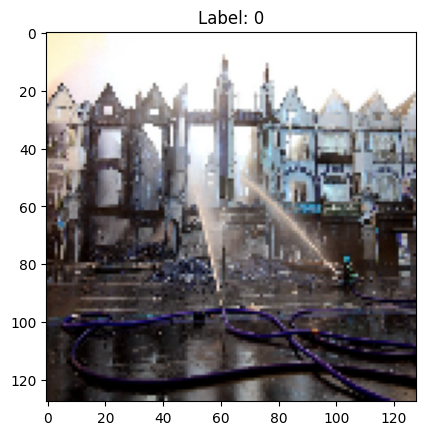

In [475]:
# Visualizing a random image from the dataset
ind = np.random.randint(0, len(images))
plt.imshow(images[ind])
plt.title(f'Label: {np.argmax(labels[ind])}')
plt.show()


In [476]:
# Calculate class weights
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals


In [477]:
# Create class weight dictionary
d = {}
d[0] = classWeight[0]
d[1] = classWeight[1]
d


{0: 1.0, 1: inf}

In [478]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, shuffle=True, random_state=42)

In [479]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [480]:
# Build the model
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16, (7, 7), padding='same', input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

# Compile the model
opt = SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

print(model.summary())


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_96             │ (None, 128, 128, 16)   │           211 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_168 (Activation)     │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_144         │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_97             │ (None, 64, 64, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_169 (Activation)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_145         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_98             │ (None, 32, 32, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_170 (Activation)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_146         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_99             │ (None, 32, 32, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_171 (Activation)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_147         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_172 (Activation)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_148         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,123,813 (8.10 MB)

 Trainable params: 2,122,949 (8.10 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [485]:
print("[INFO] training network...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=d,
    verbose=1
)


[INFO] training network...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 0.9845 - loss: 0.1103 - val_accuracy: 1.0000 - val_loss: 0.0540
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9844 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss: 0.0535
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step - accuracy: 0.9771 - loss: 0.1055 - val_accuracy: 1.0000 - val_loss: 0.0528
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0815 - val_accuracy: 1.0000 - val_loss: 0.0523
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 1.0000 - loss: 0.0800 - val_accuracy: 1.0000 - val_loss: 0.0508


In [486]:
# Save the model in the native Keras format
saved_model_path = os.path.join(output_dir, 'fire_detection.keras')
print("[INFO] serializing network to '{}'...".format(saved_model_path))
os.makedirs(output_dir, exist_ok=True)
model.save(saved_model_path)

[INFO] serializing network to '/Users/surajojha/Downloads/output/fire_detection.keras'...


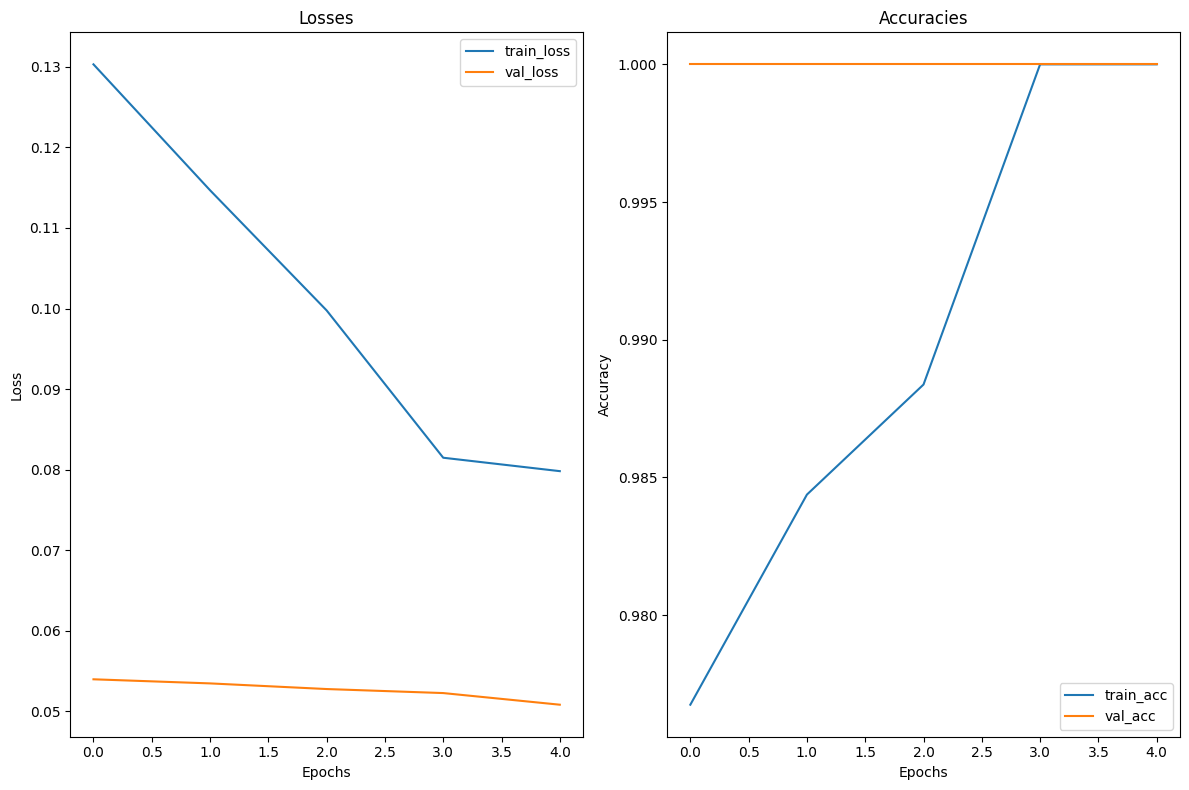

In [487]:
# Plot training history
N = np.arange(0, NUM_EPOCHS)

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(121)
plt.title("Losses")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(122)
plt.title("Accuracies")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "training_plot.png"))
plt.show()


In [488]:
# Load the trained model from disk
print("[INFO] loading model...")
loaded_model = tf.keras.models.load_model(saved_model_path)

# Optionally, recompile the model (if you plan to train or evaluate again)
loaded_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,  # Use the same optimizer settings as before
    metrics=['accuracy']
)

[INFO] loading model...


In [489]:
# Load the trained model from disk
print("[INFO] loading model...")
loaded_model = tf.keras.models.load_model(saved_model_path)



[INFO] loading model...


In [490]:
# Optionally, recompile the model (if you plan to train or evaluate again)
loaded_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,  # Use the same optimizer settings as before
    metrics=['accuracy']
)

In [491]:
# Make sure the output directory for testing images exists
testing_output_dir = os.path.join(output_dir, 'testing')
os.makedirs(testing_output_dir, exist_ok=True)



In [492]:
# Iterate over test images
for i in range(50):
    random_index = np.random.randint(0, len(X_test))
    org_img = X_test[random_index] * 255
    img = cv2.resize(org_img, (128, 128))
    img = img.astype('float32') / 255.0
    pred = loaded_model.predict(img[None, ...])
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img, (500, 500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 3)
    cv2.imwrite(f'{testing_output_dir}/{i}.png', org_img)

print("Model training, saving, and testing completed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━